In [1]:
import molsysmt as msm
from molsysmt import pyunitwizard as puw
import omembrane as omem
import openmm as mm
from openmm import app as app
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
from sys import stdout

from openmm import LocalEnergyMinimizer

In [2]:
molsys = msm.convert('memb_popc_100_stage_3_0.h5msm')

In [3]:
P_atoms = msm.select(molsys, selection='atom_type=="P" and molecule_type=="lipid"')
N_atoms = msm.select(molsys, selection='atom_type=="N" and molecule_type=="lipid"')
O_atoms = msm.select(molsys, selection='atom_type=="O" and molecule_type=="lipid"')
C_atoms = msm.select(molsys, selection='atom_type=="C" and molecule_type=="lipid"')
OW_atoms = msm.select(molsys, selection='atom_type=="O" and molecule_type=="water"')

PO_heads_atoms = msm.select(molsys, selection='atom_name in ["P","O11","O12","O13","O14"] and molecule_type=="lipid"')

In [4]:
topology = msm.convert(molsys, 'openmm.topology')
positions = msm.get(molsys, coordinates=True)

In [5]:
forcefield = mm.app.ForceField("amber14-all.xml", "amber14/tip3p.xml")

In [6]:
system = forcefield.createSystem(topology, nonbondedMethod=app.PME, nonbondedCutoff=1.2*u.nanometer, constraints=app.HBonds)

In [7]:
friction = 1 / u.picosecond
timestep = 2 * u.femtoseconds
temperature = 0.0 * u.kelvin
integrator = mm.LangevinIntegrator(temperature, friction, timestep)

In [8]:
pressure = 1.0 * u.bar
surface_tension = 0.0 * u.bar * u.nanometer
xymode = 0
zmode = 0
barostat_frequency = 25

barostat = mm.MonteCarloMembraneBarostat(pressure, surface_tension, temperature, xymode, zmode, barostat_frequency)

# Añadir el barostato al sistema
system.addForce(barostat)

5

In [9]:
platform = mm.Platform.getPlatformByName("CUDA")

In [10]:
simulation = app.Simulation(topology, system, integrator, platform)
simulation.context.setPositions(msm.pyunitwizard.convert(positions[0], to_form='openmm.unit'))

In [11]:
msm.thirds.openmm.forces.harmonic_potential_to_plane(simulation.context, selection=PO_heads_atoms,
                                                     force_constant=5000.0*u.kilojoules_per_mole/(u.nanometer**2),
                                                     point=None, vector=[0,0,1], pbc=True, adding_force=True)

6

In [12]:
simulation.minimizeEnergy()

In [13]:
state_init = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

In [14]:
reporter = app.StateDataReporter(stdout, 10000, step=True, potentialEnergy=True, temperature=True, volume=True)
simulation.reporters = [reporter]

In [15]:
temperature=50*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(50000) # 100 ps

temperature=100*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(50000) # 100 ps

temperature=150*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(50000) # 100 ps

temperature=200*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(50000) # 100 ps

temperature=250*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(50000) # 100 ps

temperature=300*u.kelvin
simulation.integrator.setTemperature(temperature)
barostat.setDefaultTemperature(temperature)
simulation.context.reinitialize(preserveState=True)
simulation.step(250000) # 100 ps

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
10000,-859239.2538315463,50.05456557315695,673.2605491318388
20000,-860683.0560684772,50.23832693993399,672.0164144227897
30000,-861501.6618949897,50.410326833345586,670.2585530371491
40000,-861959.4040278881,50.130850077186764,669.8248506652476
50000,-862685.6011612429,50.05412562354261,669.0001579563623
60000,-831961.0176949818,99.79345073391099,668.0437963447141
70000,-833482.5669792746,99.63801559041204,666.145643557005
80000,-834862.0317331003,99.82504712354678,664.8865763559187
90000,-835427.5503584403,99.79052883981099,664.1483634643898
100000,-835935.3384245383,100.39514115051955,662.959454857116
110000,-802421.1436739825,150.1532981555862,661.4719415775529
120000,-804683.986489437,150.00890816684367,657.9285491075448
130000,-806343.7946770545,150.28860948961784,653.5912200834947
140000,-806644.4520100811,149.395505974638,651.8065843637693
150000,-807309.497401943,150.60574177196972,650.6291096372956
160

In [16]:
state_end = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

/fast_data/home/diego/miniconda3/envs/OMembrane@uibcdf_3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


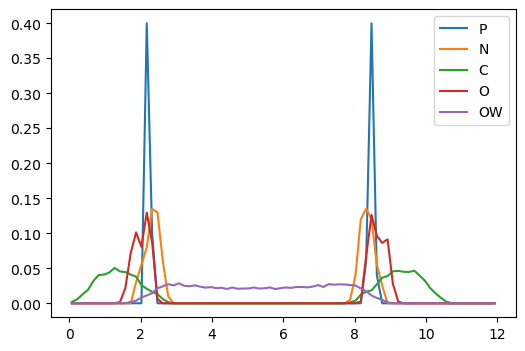

In [17]:
bins_edges_P_init, density_P_init = omem.analysis.get_lineal_density(state_init, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_N_init, density_N_init = omem.analysis.get_lineal_density(state_init, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_C_init, density_C_init = omem.analysis.get_lineal_density(state_init, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_O_init, density_O_init = omem.analysis.get_lineal_density(state_init, selection = O_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_OW_init, density_OW_init = omem.analysis.get_lineal_density(state_init, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)


plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_init[1:]+bins_edges_P_init[:-1])/2, density_P_init, label='P')
plt.plot((bins_edges_N_init[1:]+bins_edges_N_init[:-1])/2, density_N_init, label='N')
plt.plot((bins_edges_C_init[1:]+bins_edges_C_init[:-1])/2, density_C_init, label='C')
plt.plot((bins_edges_O_init[1:]+bins_edges_O_init[:-1])/2, density_O_init, label='O')
plt.plot((bins_edges_OW_init[1:]+bins_edges_OW_init[:-1])/2, density_OW_init, label='OW')
plt.legend()

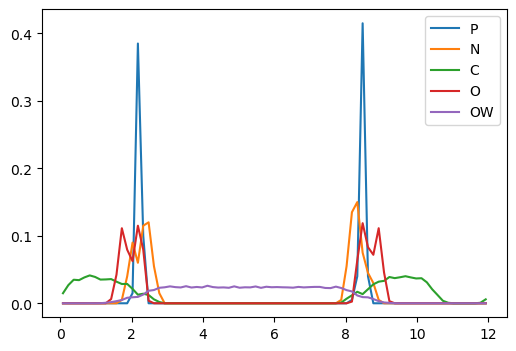

In [18]:
bins_edges_P_end, density_P_end = omem.analysis.get_lineal_density(state_end, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_N_end, density_N_end = omem.analysis.get_lineal_density(state_end, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_C_end, density_C_end = omem.analysis.get_lineal_density(state_end, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_O_end, density_O_end = omem.analysis.get_lineal_density(state_end, selection = O_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_OW_end, density_OW_end = omem.analysis.get_lineal_density(state_end, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)

plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_end[1:]+bins_edges_P_end[:-1])/2, density_P_end, label='P')
plt.plot((bins_edges_N_end[1:]+bins_edges_N_end[:-1])/2, density_N_end, label='N')
plt.plot((bins_edges_C_end[1:]+bins_edges_C_end[:-1])/2, density_C_end, label='C')
plt.plot((bins_edges_O_end[1:]+bins_edges_O_end[:-1])/2, density_O_end, label='O')
plt.plot((bins_edges_OW_end[1:]+bins_edges_OW_end[:-1])/2, density_OW_end, label='OW')
plt.legend()
plt.show()

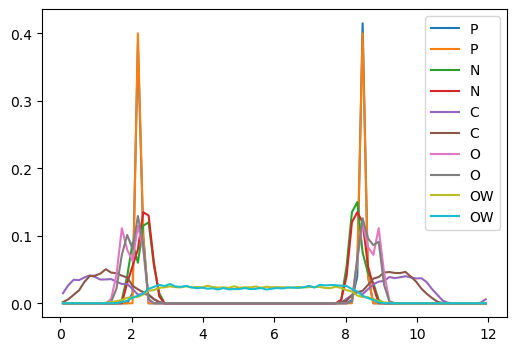

In [19]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_end[1:]+bins_edges_P_end[:-1])/2, density_P_end, label='P')
plt.plot((bins_edges_P_init[1:]+bins_edges_P_init[:-1])/2, density_P_init, label='P')

plt.plot((bins_edges_N_end[1:]+bins_edges_N_end[:-1])/2, density_N_end, label='N')
plt.plot((bins_edges_N_init[1:]+bins_edges_N_init[:-1])/2, density_N_init, label='N')

plt.plot((bins_edges_C_end[1:]+bins_edges_C_end[:-1])/2, density_C_end, label='C')
plt.plot((bins_edges_C_init[1:]+bins_edges_C_init[:-1])/2, density_C_init, label='C')

plt.plot((bins_edges_O_end[1:]+bins_edges_O_end[:-1])/2, density_O_end, label='O')
plt.plot((bins_edges_O_init[1:]+bins_edges_O_init[:-1])/2, density_O_init, label='O')

plt.plot((bins_edges_OW_end[1:]+bins_edges_OW_end[:-1])/2, density_OW_end, label='OW')
plt.plot((bins_edges_OW_init[1:]+bins_edges_OW_init[:-1])/2, density_OW_init, label='OW')

plt.legend()
plt.show()

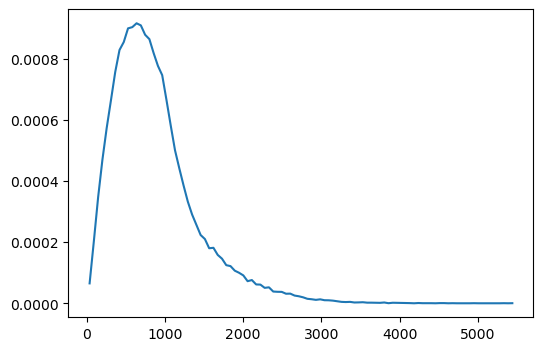

In [20]:
forces = msm.molecular_mechanics.get_forces(simulation.context, norm=True)
h, bins = np.histogram(puw.get_value(forces), bins=100, density=True)
plt.plot(0.5*(bins[1:]+bins[:-1]), h)
plt.show()

In [21]:
#memb_antes = msm.extract(molsys, selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')
#memb_despues = msm.extract([molsys, simulation.context], selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')

In [22]:
#msm.view(memb_despues)

In [28]:
coordinates = msm.get(state_end, coordinates=True)
box = msm.get(state_end, box=True)
msm.set(molsys, coordinates=coordinates, box=box)

In [24]:
msm.view(molsys, standard=False)

NGLWidget()

In [29]:
msm.convert(molsys, 'memb_popc_100_stage_3_1.h5msm')

'memb_popc_100_stage_3_1.h5msm'

In [30]:
msm.get(molsys, box=True)

Magnitude,[[[7.512268316909586 0.0 0.0] [0.0 7.512268316909586 0.0] [0.0 0.0 10.507842309870016]]]
Units,nanometer


In [31]:
7.51**2/100

0.564001